<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import scipy.optimize as opt


import seaborn as sns
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-20 00:35:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-04-20 00:35:44 (10.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [3]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-20 00:35:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-20 00:35:44 (683 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
test_df = pd.read_csv('loan_test.csv')
#df.head()

In [5]:
#df.shape

### Convert to date time object 

In [6]:
def clean_df (df):
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    df.head()
    
clean_df(df)    
clean_df(test_df)    

# Data visualization and pre-processing



# Utility Plot Functions


In [7]:
def plot_gender(df):
    bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'Principal', bins=bins, ec="k")

    g.axes[-1].legend()
    plt.show()

In [8]:
def plot_age(df):
    bins = np.linspace(df.age.min(), df.age.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'age', bins=bins, ec="k")

    g.axes[-1].legend()
    plt.show()

In [9]:
def plot_dayOfWeek(df):
    bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
    g.axes[-1].legend()
    plt.show()


Let’s see how many of each class is in our data set 

Visualize DF  TRAIN (346, 12)
PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64


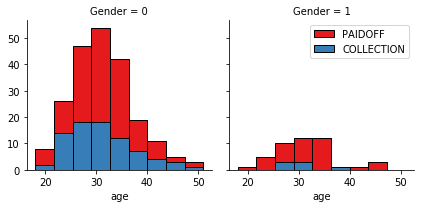

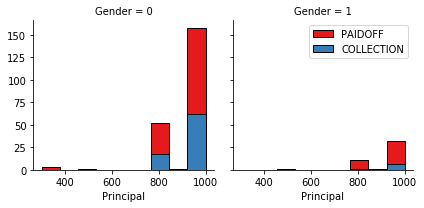

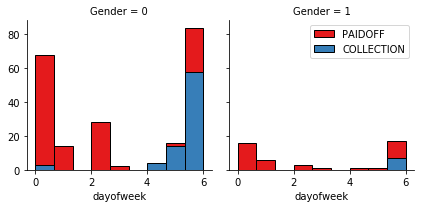

Gender  loan_status
0       PAIDOFF        0.731293
        COLLECTION     0.268707
1       PAIDOFF        0.865385
        COLLECTION     0.134615
Name: loan_status, dtype: float64
education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64


In [10]:
def visualize (df, name):
    
    print("Visualize DF ",name,df.shape)
    print(df['loan_status'].value_counts())
    plot_age(df)
    plot_gender(df)
    plot_dayOfWeek(df)
    print(df.groupby(['Gender'])['loan_status'].value_counts(normalize=True))
    print(df.groupby(['education'])['loan_status'].value_counts(normalize=True))
    
visualize(df,"TRAIN")


Visualize DF  TEST (54, 12)
PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64


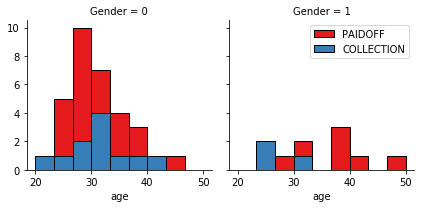

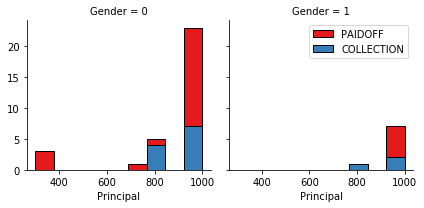

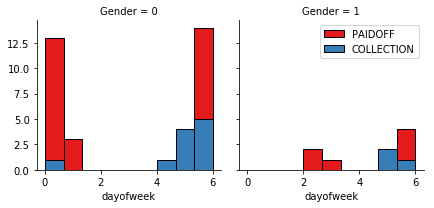

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64
education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64


In [11]:
visualize(test_df,"TEST")

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [12]:
# notice: installing seaborn might takes a few minutes
# uncomment as required
#!conda install -c anaconda seaborn -y

In [13]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [14]:
#df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#df.head()

## Convert Categorical features to numerical values

Lets look at gender:

In [15]:
#df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [16]:
#df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#df.head()

## One Hot Encoding  
#### How about education?

In [17]:
#df.groupby(['education'])['loan_status'].value_counts(normalize=True)

#### Feature befor One Hot Encoding

In [18]:
#df[['Principal','terms','age','Gender','education']].head()

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [19]:
def get_samples(df):
    X = df[['Principal','terms','age','Gender','weekend']]
    X = pd.concat([X,pd.get_dummies(df['education'])], axis=1)
    X.drop(['Master or Above'], axis = 1,inplace=True)
    y2 = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0]).values
    y = df['loan_status'].values
    x_scaled = preprocessing.StandardScaler().fit(X).transform(X)
    return X.values, x_scaled, y, y2
    
#a, b, c, d = get_samples(df)

### Feature selection

Lets defind feature sets, X:

In [20]:
#X = Feature
#X[0:5]

What are our lables?

In [21]:
#y2 = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0])
#y = df['loan_status'].values
#y2[0:5]

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [22]:
#Xs= preprocessing.StandardScaler().fit(X).transform(X)
#Xs[0:5]

# Reporting and Plotting Utilitiy Routines

In [23]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [25]:
#Set up the Report
report = pd.DataFrame([
    ('KNN',0,0,0),
    ('Decision Tree',0,0,0),
    ('SVM',0,0,0),
    ('LogisticRegression',0,0,0)])

report.columns = ['Algorithm','Jaccard','F1','Logloss']
report.set_index('Algorithm',inplace=True)

def add_report(key, jaccard, f1, logloss):
    report.loc[key] = [jaccard, f1, logloss]
    
def print_report():
    print(report)
    
def jaccard(yhat, y_test):
    return jaccard_similarity_score(y_test, yhat)

def F1(yhat, y_test):
    newYHat = []
    for i in range(0, len(yhat)): 
        data = yhat[i]
        if (data == "PAIDOFF"):
            newYHat.append(1)
        if (data != "PAIDOFF"):
            newYHat.append(0)
            
    newYTest = []
    for i in range(0, len(y_test)): 
        data = y_test[i]
        if (data == "PAIDOFF"):
            newYTest.append(1)
        if (data != "PAIDOFF"):
            newYTest.append(0)
        
#    print(f1_score(newYTest, newYHat, average='weighted'))
    return f1_score(newYTest, newYHat, average='weighted')
#
#
#
def logloss(yhat, y_test):
    newYHat = []
    for i in range(0, len(yhat)): 
        data = yhat[i]
        if (data == "PAIDOFF"):
            newYHat.append(1)
        if (data != "PAIDOFF"):
            newYHat.append(0)
            
    newYTest = []
    for i in range(0, len(y_test)): 
        data = y_test[i]
        if (data == "PAIDOFF"):
            newYTest.append(1)
        if (data != "PAIDOFF"):
            newYTest.append(0)
        
    return log_loss(newYTest, newYHat)

#do_LR(X, y, X_Test, Y_Test)

In [26]:
 def report_on(name, yhat, Y_Test, thirdReport=False):
    print(name,"Accuracy: ", metrics.accuracy_score(Y_Test, yhat))
    lastOne = "NA"
    if thirdReport:
        lastOne = logloss(yhat,Y_Test)
        
    add_report(name, jaccard(yhat,Y_Test), F1(yhat,Y_Test), lastOne)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y_Test, yhat)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, 
                          classes=['COLLECTION','PAIDOFF'],
                          normalize= False,  
                          title='Confusion matrix for ' + name)



In [27]:
#This gets all the sample data I can think of and puts it in a convenient place
a,b,c,d = get_samples(df)
A,B,C,D = get_samples(test_df)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [28]:
def knn (X_Train, Y_Train, X_Test, Y_Test, k=4):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_Train,Y_Train)
    return neigh.predict(X_Test)


In [29]:
def knn_best_k (X_Train, Y_Train, X_Test, Y_Test):
    k = 1
    best = 0
    Ks = 10
    mean_acc = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    ConfustionMx = [];
    for n in range(1,Ks):
        #Train Model and Predict  
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_Train,Y_Train)
        yhat=neigh.predict(X_Test)
        mean_acc[n-1] = metrics.accuracy_score(Y_Test, yhat)
        if ( mean_acc[n-1] > best):
            k = n
            best = mean_acc[n-1]
            
        std_acc[n-1]=np.std(yhat==Y_Test)/np.sqrt(yhat.shape[0])
        
    plt.plot(range(1,Ks),mean_acc,'g')
    plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Number of Neighbors (K)')
    plt.title('Accuracy of KNN for values of K')
    plt.tight_layout()
    plt.show()    
        
    print("KNN thinks the best K value is ",k)
    return k


In [30]:
# I added this layer so that I could transform the data
# But I found it was not really neccessary

def xform_knn_data (x):
    y = pd.DataFrame(x)
    print(y.columns)
    return x

In [31]:
# This is the basic form for doing any analysis
# pass the training and test data
# get the yHat data and report on it
# in KNN's case we add a graph to illustrate the best K value

def do_KNN (X_Train, Y_Train, X_Test, Y_Test):
    x_1 = xform_knn_data(X_Train)
    x_2 = xform_knn_data(X_Test)
    k = knn_best_k (x_1, Y_Train, x_2, Y_Test)
    yhat = knn(X_Train, Y_Train, X_Test, Y_Test, k)

    report_on("KNN",yhat,Y_Test)
    

def try_KNN():
#    a,b,c,d = get_samples(df)
#    A,B,C,D = get_samples(test_df)
#    print(b,c,B,C)
    do_KNN(b, c, B, C)
    
#try_KNN()


# Decision Tree

In [32]:
#from sklearn.externals.six import StringIO 
#from IPython.display import Image  
#from sklearn.tree import export_graphviz
#import pydotplus

def do_DTREE (X_Train, Y_Train, X_Test, Y_Test):
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

    loanTree.fit(X_Train,Y_Train)
    yhat = loanTree.predict(X_Test)
    report_on('Decision Tree',yhat,Y_Test)
       
#    dot_data = StringIO()
#    export_graphviz(loanTree, out_file=dot_data,  
#                    filled=True, rounded=True,
#                    special_characters=True)
#    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#    Image(graph.create_png())
    # Create PDF
#    graph.write_pdf("iris.pdf")
    # Create PNG
#    graph.write_png("iris.png")

#print(X[0:10])

def try_DTREE():
#    a,b,c,d = get_samples(df)
#    A,B,C,D = get_samples(test_df)
#    print(b,c,B,C)
    do_DTREE(b, c, B, C)
    
#try_DTREE()
#print_report()

# Support Vector Machine

In [33]:

def do_SVM (X_Train, Y_Train, X_Test, Y_Test):
    clf = svm.SVC(kernel='sigmoid',gamma='auto')
    clf.fit(X_Train, Y_Train) 
    yhat = clf.predict(X_Test)
    report_on("SVM", yhat,Y_Test)

def try_SVM():
#    a,b,c,d = get_samples(df)
#    A,B,C,D = get_samples(test_df)
#    print(b,d,B,D)
    do_SVM(b, c, B, C)
    
#try_SVM()
#print_report()

# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def do_LR (X_Train, Y_Train, X_Test, Y_Test):
    LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_Train,Y_Train)
    yhat = LR.predict(X_Test)
    
    report_on("LogisticRegression",yhat,Y_Test,True)

def try_LR():
    do_LR(a, c, A, C)
    
#try_LR()
#print_report()

# Model Evaluation using Test set

First, download and load the test set:

In [35]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Run the Four Methods against Test set for evaluation 

RangeIndex(start=0, stop=8, step=1)
RangeIndex(start=0, stop=8, step=1)


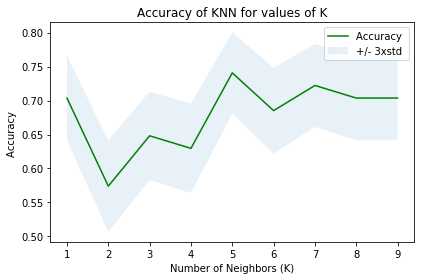

KNN thinks the best K value is  5
KNN Accuracy:  0.740740740741
Confusion matrix, without normalization
[[ 5  9]
 [ 5 35]]
Decision Tree Accuracy:  0.777777777778
Confusion matrix, without normalization
[[ 3 11]
 [ 1 39]]
SVM Accuracy:  0.685185185185
Confusion matrix, without normalization
[[ 1 13]
 [ 4 36]]
LogisticRegression Accuracy:  0.740740740741
Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


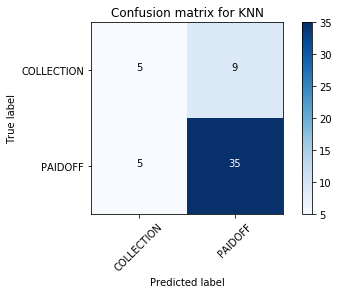

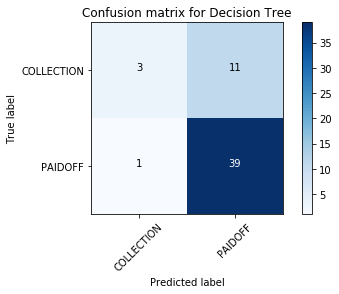

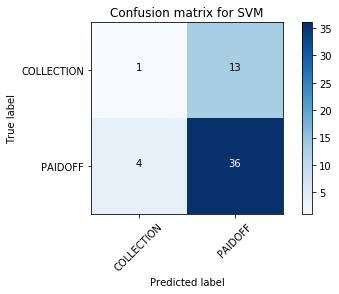

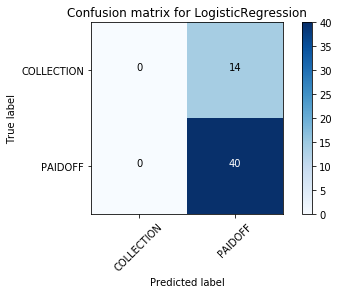

In [36]:
try_KNN()
try_DTREE()
try_SVM()
try_LR()


# My Report

Based on this analysis the Decision Tree had the best results followed by KNN
They both had a lot of false negatives, particularly in COLLECTIONS that were idenified as PAIDOFFs. They all did well in identifying PAIDOFF correctly, but Decision Tree was the shining example. However, KNN did best at correctly identifying COLLECTIONS. See Below...

In [37]:
print_report()

                     Jaccard        F1 Logloss
Algorithm                                     
KNN                 0.740741  0.725309      NA
Decision Tree       0.777778  0.728395      NA
SVM                 0.685185  0.626541      NA
LogisticRegression  0.740741  0.630418  8.9547


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>